In [ ]:
from IPython import get_ipython
from IPython.display import display, clear_output # Import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import numpy as npa
import math
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback # Import Callback
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

# **Data preparation**

In [ ]:
BATCH_SIZE = 128 # Batch size for training
HPO_TRAIN_SIZE = 10000 # Size of the training set for hyperparameter optimization
NUM_CLASSES = 10 # Number of classes in the dataset
EPOCHS_CV = 15 # Epochs for final cross-validation
EPOCHS_HPO = 10 # Epochs for hyperparameter optimization
MAX_TRIALS_HPO = 20 # Maximum number of trials for hyperparameter optimization

In [ ]:
print("Loading and preparing KMNIST dataset...")
(ds_train, ds_test), ds_info = tfds.load(
    'kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True
)

Loading and preparing KMNIST dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.403W0X_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.403W0X_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(image, label):
    # Flatten the 28x28 image to a 784 vector and normalize
    image = tf.cast(image, tf.float32) / 255.0 # normalize pixel values to 0,1 
    image = tf.reshape(image, [-1]) # flatten the image 
    return image, label

In [ ]:
# Create tf.data.Dataset versions for efficient HPO
ds_hpo = ds_train.map(preprocess).shuffle(60000).batch(BATCH_SIZE) # shuffles the dataset and creates batches
ds_train_hpo = ds_hpo.take(int(0.9 * len(ds_hpo))) # 90% training data
ds_val_hpo = ds_hpo.skip(int(0.9 * len(ds_hpo))) # 90% validation data

In [ ]:
# Create NumPy array versions for K-Fold Cross-Validation
train_images_np = np.array([x[0].numpy() for x in ds_train]) # Convert images to np array
train_labels_np = np.array([x[1].numpy() for x in ds_train]) # Convert labels to np array
# Flatten the images to match the model's input layer
train_images_np = train_images_np.reshape(train_images_np.shape[0], -1)


# **Model definition**

So we have 4 layers in total,



*   Input layer: 748 neurons, because we have 784 input
*   2 Hidden layers,
          1. First layer: 128 neurons / relu activation function
          2. Second layer: 64 neurons / relu activation function
*   Output layer: 10 as we have 10 classes. We're using Softmax cause it apparently works with crossentropy.











In [ ]:
def FFN_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)), # input layer to 784 28x28 pixels flattened
        tf.keras.layers.Dense(units=128, activation='relu'),  #first hidden layer with 128 neurons and relu activation function
        tf.keras.layers.Dense(units=64, activation='relu'), #second hidden layer with 64 neurons and relu activation function
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax') # output layer with softmax activation function for multi-class classification
    ])

    optimizer_name = hp.Fixed('optimizer', hp.get('optimizer')) # hyperparameter initialization

    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log') # hyperparameter  setup for learning rate

    # Choose optimizer based on the hyperparameter
    # If 'adam', 'adamw', or 'rmsprop' is selected, set up the optimizer accordingly
    # 'adam' is the default optimizer, 'adamw' is Adam with weight decay, and 'rmsprop' is RMSprop optimizer.
    # The hyperparameters for each optimizer are defined with ranges for tuning.
    # The optimizer is then compiled with the model.
    # This allows for flexibility in choosing the optimizer and its parameters during hyperparameter tuning.
    # depending on the optimizer selected, different hyperparameters are tuned
    # 'adam' optimizer has beta_1, beta_2, epsilon, and amsgrad hyperparameters
    # 'adamw' optimizer has weight_decay, beta_1, beta_2, epsilon, and amsgrad hyperparameters
    # 'rmsprop' optimizer has rho, momentum, epsilon, and centered hyperparameters
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=learning_rate,
            beta_1=hp.Float('beta_1', min_value=0.8, max_value=0.99),
            beta_2=hp.Float('beta_2', min_value=0.9, max_value=0.9999),
            epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log'),
            amsgrad=hp.Boolean('amsgrad')
        )
    elif optimizer_name == 'adamw':
        weight_decay = hp.Float('weight_decay', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            beta_1=hp.Float('beta_1', min_value=0.8, max_value=0.99),
            beta_2=hp.Float('beta_2', min_value=0.9, max_value=0.9999),
            epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log'),
            amsgrad=hp.Boolean('amsgrad')
        )
    else:
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=learning_rate,
            rho=hp.Float('rho', min_value=0.8, max_value=0.99),
            momentum=hp.Float('momentum', min_value=0.0, max_value=0.9),
            epsilon=hp.Float('epsilon', min_value=1e-8, max_value=1e-6, sampling='log'),
            centered=hp.Boolean('centered')
        )

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# **HPO and 5-Fold CV Execution**
This is the core execution cell. It loops through each optimizer, finds its best hyperparameters, and then immediately runs a 5-Fold CV with those settings, saving the results after each optimizer to prevent data loss.

In [ ]:
# Custom Callback for Live Trial Logging and Plotting 
class TrialLogger(Callback):
    def __init__(self, tuner, optimizer_name):
        super().__init__()
        self.tuner = tuner # Reference to the tuner instance
        self.optimizer_name = optimizer_name # Name of the optimizer being tuned
        self.trial_scores = [] # List to store scores of each trial
        self.trial_params = [] # List to store hyperparameters of each trial

    # Callback methods to log and visualize the trials
    def on_trial_begin(self, trial):
        clear_output(wait=True) 
        print(f"\n{'='*20} Processing Optimizer: {self.optimizer_name.upper()} {'='*20}")
        print(f"--- Starting Trial {len(self.trial_scores) + 1}/{self.tuner.max_trials} ---")

    def on_trial_end(self, trial):
        # Get score and params and store them
        score = trial.metrics.get_best_value('val_accuracy') # Get the best validation accuracy for the trial
        self.trial_scores.append(score) # Append the score to the trial scores list
        self.trial_params.append(trial.hyperparameters.values) # Append the hyperparameters to the trial params list

        
        # This will display the best score and parameters for the current trial
        # It helps in tracking the progress of hyperparameter tuning.
        # It also provides insights into the performance of different hyperparameter configurations.
        print("\n--- Trial Log ---")
        header_printed = False
        for i, (params, s) in enumerate(zip(self.trial_params, self.trial_scores)):
            if not header_printed:
                header = " | ".join([f"{key:<15}" for key in params.keys() if key != 'optimizer'])
                print(f"{'TRIAL':<7} | {'SCORE':<10} | {header}")
                print("-" * (len(header) + 22))
                header_printed = True

            param_str = " | ".join([f"{params[key]:<15.5f}" if isinstance(params[key], float) else f"{str(params[key]):<15}" for key in params.keys() if key != 'optimizer'])
            print(f"{i+1:<7} | {s:<10.4f} | {param_str}")


# we are storing all the optimizer results in this following lines
all_optimizer_results = [] # List to store results of all optimizers
all_optimizer_histories = {} # Dictionary to store training histories of all optimizers
all_tuners = {} # Dictionary to store tuner instances for each optimizer
results_dir = 'final_results_bayesian_live' 
os.makedirs(results_dir, exist_ok=True)

OPTIMIZERS_TO_TEST = ['adam', 'adamw', 'rmsprop']

# Loop through each optimizer and perform hyperparameter tuning
# This section iterates over the list of optimizers to test, initializes hyperparameters, and performs Bayesian optimization for each optimizer.
# It also logs the results and performs 5-fold cross-validation on the best hyperparameters found.
# The results are stored in a directory for later analysis.
for optimizer_name in OPTIMIZERS_TO_TEST:
    hp = kt.HyperParameters()
    hp.Fixed('optimizer', optimizer_name)

    tuner = kt.BayesianOptimization(
        hypermodel=FFN_model, # The model to be tuned
        hyperparameters=hp, # Hyperparameters to be tuned
        objective='val_accuracy', # Objective to optimize
        max_trials=MAX_TRIALS_HPO, # Maximum number of trials for hyperparameter optimization. THey are defined in the beginning
        directory='bayesian_hpo_dir_live', # directory to store the tuning results
        project_name=f'kmnist_bayes_{optimizer_name}', # Project name for the tuning results
        overwrite=True # Overwrite existing results in the directory
    )

    logger_callback = TrialLogger(tuner, optimizer_name) # Custom callback for logging and visualizing trials [but since we're clearing the output, it won't show the live updates in this notebook]
    tuner.search(ds_train_hpo, epochs=EPOCHS_HPO, validation_data=ds_val_hpo, verbose=0, callbacks=[logger_callback]) # this line starts the hpo 

    clear_output(wait=True) # here clearing
    print(f"\n{'='*20} HPO Finished for: {optimizer_name.upper()} {'='*20}")  

    # the following lines are used to store the results of the tuning
    # then we perform k-fold cross-validation on the best hyperparameters found
    # # We store the tuner instance, best hyperparameters, and results in dictionaries for later use

    all_tuners[optimizer_name] = tuner
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # Get the best hyperparameters from the tuner
    print(f"  > Best HPs found for {optimizer_name.upper()}.") 

    # 5-Fold on the best hyperparameters
    print("  > Running 5-Fold Cross-Validation on best HPs...")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42) 
    fold_accuracies, fold_losses, fold_times = [], [], []

    # Initialize lists to store results for each fold
    # We use kfoold from sklearn to split the training data into 5 folds for cross-validation
    # The model is trained on each fold, and the accuracy, loss, and training time are recorded.
    # The results are stored in lists for each fold, and the average and standard deviation are calculated at the end.
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_images_np, train_labels_np), 1):
        model = tuner.hypermodel.build(best_hps)
        start_time = time.time() # Start time for measuring training time
        # Train the model on the current fold
        history = model.fit(train_images_np[train_idx], train_labels_np[train_idx], epochs=EPOCHS_CV, batch_size=BATCH_SIZE, validation_data=(train_images_np[val_idx], train_labels_np[val_idx]), verbose=0)
        end_time = time.time() # End time for measuring training time

        if fold == 1: # Save the training history of the first fold
            all_optimizer_histories[optimizer_name] = history # Store the training history of the first fold for this optimizer

        scores = model.evaluate(train_images_np[val_idx], train_labels_np[val_idx], verbose=0)
        fold_accuracies.append(scores[1]); fold_losses.append(scores[0]); fold_times.append(end_time - start_time)


    optimizer_result = {'Optimizer': optimizer_name.upper(), 'Avg. Accuracy': np.mean(fold_accuracies), 'Std. Dev. Accuracy': np.std(fold_accuracies), 'Avg. Loss': np.mean(fold_losses), 'Avg. Training Time (s)': np.mean(fold_times)}
    all_optimizer_results.append(optimizer_result)
    pd.DataFrame([optimizer_result]).to_csv(os.path.join(results_dir, f'results_{optimizer_name}.csv'), index=False)

results_df = pd.DataFrame(all_optimizer_results)


==================== HPO Finished for: RMSPROP ====================
  > Best HPs found for RMSPROP.
  > Running 5-Fold Cross-Validation on best HPs...


# Insights

Hyperparameter Tuning

This is the part that finds the best learning rate for each optimizer.

    Number of Optimizers to test: 3 (Adam, AdamW, RMSprop)
    Trials per Optimizer: max_trials=20
    Epochs per Trial: epochs=10

Calculation for this step:
3 optimizers × 20 trials × 10 epochs/trial = 600 total epochs (spread across 30 separate model training runs).
Step 2: 5-Fold Cross-Validation

After finding the best hyperparameters for an optimizer, this part runs the robust evaluation.

    Number of Optimizers: 3 (one at a time, after its HPO is done)
    Folds per Optimizer: n_splits=5
    Epochs per Fold: epochs=15

Calculation for this step:
3 optimizers × 5 folds × 15 epochs/fold = 225 total epochs (spread across 15 separate model training runs).
Total Project Calculation for this Cell

    Total Training Runs: 30 (from HPO) + 15 (from K-Fold) = 45 times a model is built and trained.
    Total Epochs Trained: 600 (from HPO) + 225 (from K-Fold) = 825 total epochs.

# printing the best result
The following cell prints the brest hypereparameters found by Bayesian optimization

In [ ]:
print("--- Best Hyperparameters Found by Bayesian Optimization ---")
for optimizer_name, tuner in all_tuners.items():
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0].values
    print(f"\\nOptimizer: {optimizer_name.upper()}")
    for key, value in best_hps.items():
        if key not in ['optimizer', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round']:
             print(f"  - {key:<15}: {value:.5f}" if isinstance(value, float) else f"  - {key:<15}: {value}")

print("\\n\\n--- Final Tabular Results (5-Fold CV) ---")
formatted_df = results_df.copy()
formatted_df['Avg. Accuracy'] = formatted_df['Avg. Accuracy'].map('{:.2%}'.format)
formatted_df['Std. Dev. Accuracy'] = formatted_df['Std. Dev. Accuracy'].map('{:.3%}'.format)
print(formatted_df.to_string(index=False))

--- Best Hyperparameters Found by Bayesian Optimization ---
\nOptimizer: ADAM
  - learning_rate  : 0.00505
  - beta_1         : 0.84586
  - beta_2         : 0.92635
  - epsilon        : 0.00000
  - amsgrad        : True
\nOptimizer: ADAMW
  - learning_rate  : 0.00439
  - weight_decay   : 0.00037
  - beta_1         : 0.82384
  - beta_2         : 0.92119
  - epsilon        : 0.00000
  - amsgrad        : True
\nOptimizer: RMSPROP
  - learning_rate  : 0.00034
  - rho            : 0.89780
  - momentum       : 0.72654
  - epsilon        : 0.00000
  - centered       : False
\n\n--- Final Tabular Results (5-Fold CV) ---
Optimizer Avg. Accuracy Std. Dev. Accuracy  Avg. Loss  Avg. Training Time (s)
     ADAM        85.31%             2.939%   0.576488               22.537908
    ADAMW        86.78%             2.033%   0.533316               22.263744
  RMSPROP        88.94%             2.435%   0.655122               21.527582


# Prints the learning curve for best models 

--- Plotting Learning Curves (from First CV Fold) ---


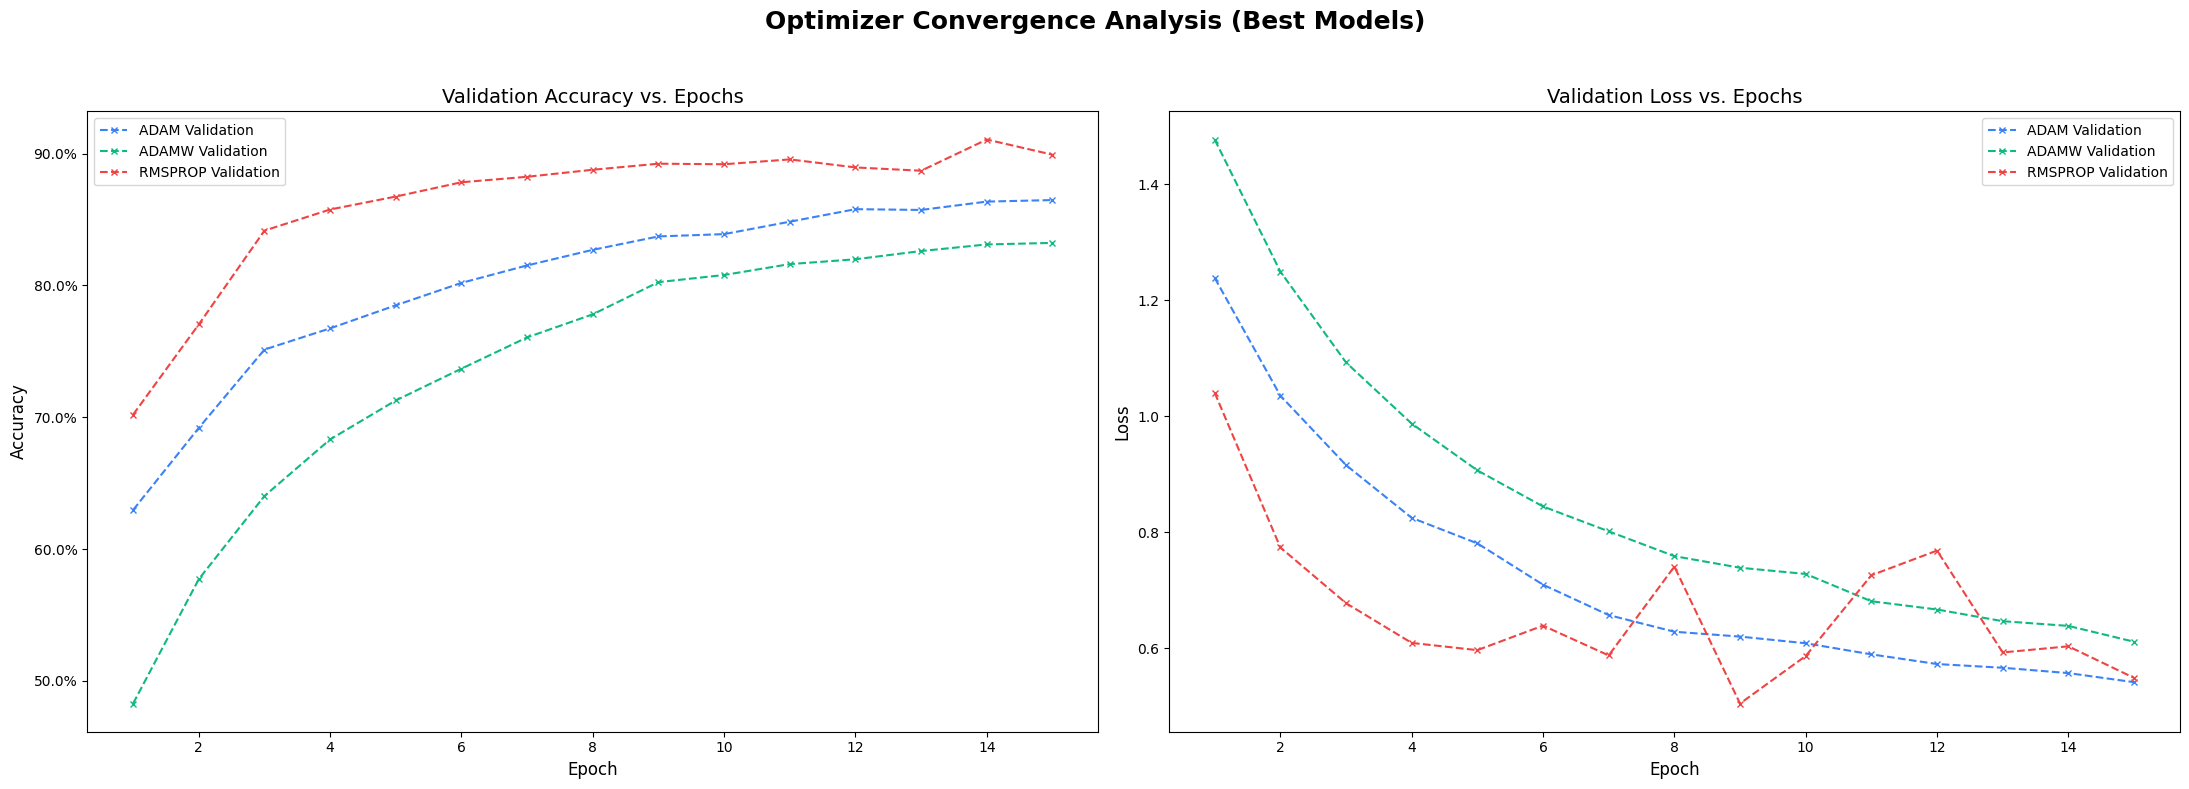

In [ ]:
print("--- Plotting Learning Curves (from First CV Fold) ---")
fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(22, 8)) 
fig.suptitle('Optimizer Convergence Analysis (Best Models)', fontsize=18, fontweight='bold')
colors = {'ADAM': '#3b82f6', 'ADAMW': '#10b981', 'RMSPROP': '#ef4444'}

for optimizer_name, history in all_optimizer_histories.items(): # Loop through each optimizer's history
    opt_name_upper = optimizer_name.upper() # Convert optimizer name to uppercase for consistent labeling
    color = colors[opt_name_upper] # Get the color for the optimizer from the predefined colors dictionary
    epochs_range = range(1, len(history.history['accuracy']) + 1) # Define the range of epochs based on the history length

    # Accuracy Plot
    ax_acc.plot(epochs_range, history.history['val_accuracy'], label=f'{opt_name_upper} Validation', color=color, linestyle='--', marker='x', markersize=5)

    # Loss Plot
    ax_loss.plot(epochs_range, history.history['val_loss'], label=f'{opt_name_upper} Validation', color=color, linestyle='--', marker='x', markersize=5)

ax_acc.set_title('Validation Accuracy vs. Epochs', fontsize=14)
ax_acc.set_xlabel('Epoch', fontsize=12)
ax_acc.set_ylabel('Accuracy', fontsize=12)
ax_acc.legend()
ax_acc.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

ax_loss.set_title('Validation Loss vs. Epochs', fontsize=14)
ax_loss.set_xlabel('Epoch', fontsize=12)
ax_loss.set_ylabel('Loss', fontsize=12)
ax_loss.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot for each hyperparameter
the following function will print the plot based on the impact of hypereparameter on each optimizer

In [ ]:
def plot_hparam_impact(tuner, optimizer_name, num_trials=50):
    """
    Processes tuner trial data and plots the impact of each hyperparameter on the score.
    """
    trials = tuner.oracle.get_best_trials(num_trials) # Get the best trials from the tuner

    hps = [trial.hyperparameters.values for trial in trials]
    scores = [trial.score for trial in trials]

    df = pd.DataFrame(hps)
    df['score'] = scores

    # Identify hyperparameter columns to plot
    hparam_cols = [col for col in df.columns if col not in ['optimizer', 'score', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round']]
    num_params = len(hparam_cols)

    if num_params == 0:
        print(f"No tunable hyperparameters found for {optimizer_name}.")
        return

    # Create subplots
    fig, axes = plt.subplots(1, num_params, figsize=(6 * num_params, 5))
    if num_params == 1: # Handle case with only one hyperparameter
        axes = [axes]

    fig.suptitle(f'Hyperparameter Impact on Validation Accuracy for {optimizer_name.upper()}', fontsize=16, fontweight='bold')

    for i, param in enumerate(hparam_cols):
        ax = axes[i]
        # Use boxplot for categorical/integer params, scatter for float params
        if df[param].nunique() <= 6: # Treat params with few unique values as categorical
             sns.boxplot(x=param, y='score', data=df, ax=ax, palette='viridis')
        else:
            sns.regplot(x=param, y='score', data=df, ax=ax, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

        ax.set_title(f'Score vs. {param}', fontsize=12)
        ax.set_ylabel('Validation Accuracy')
        ax.set_xlabel(param)

    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

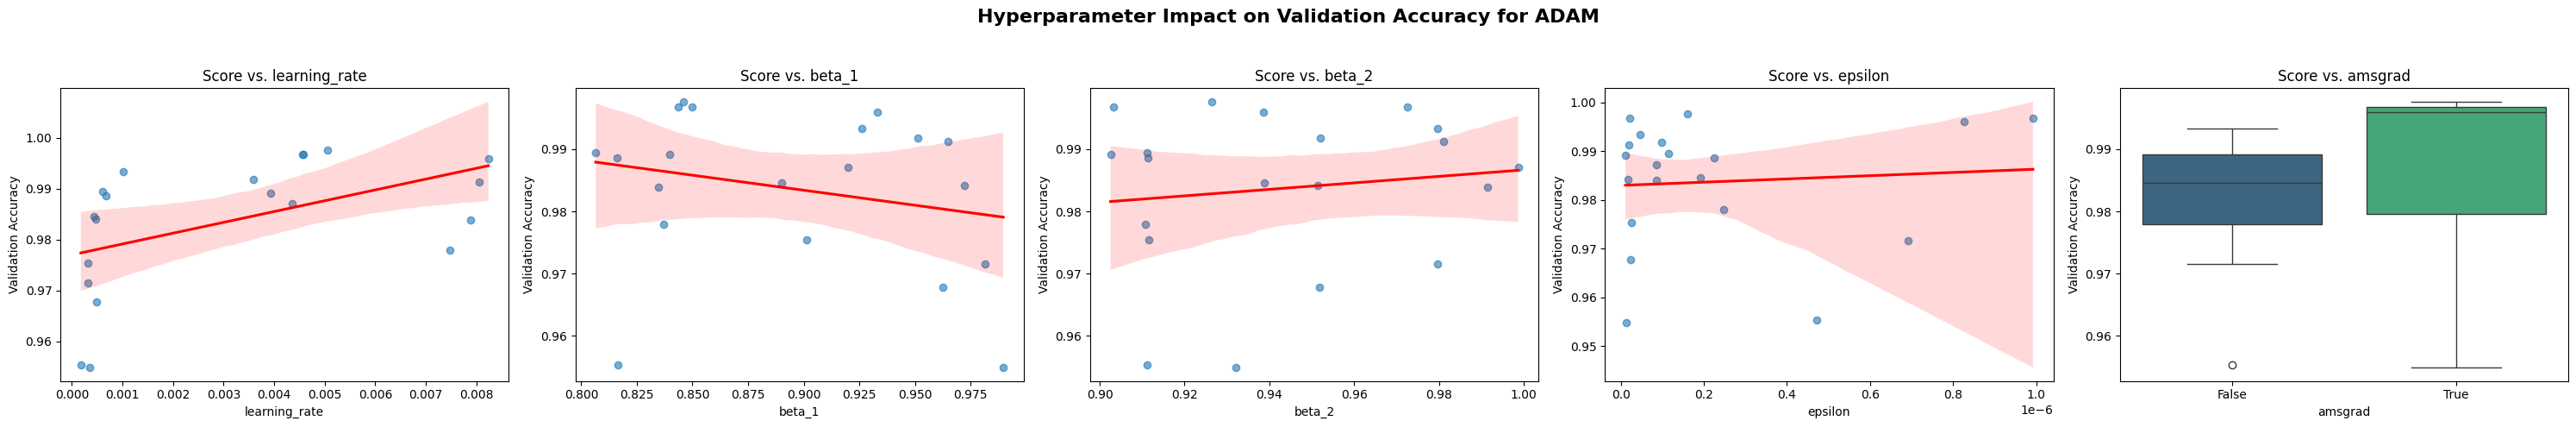

In [ ]:
plot_hparam_impact(all_tuners['adam'], 'ADAM')

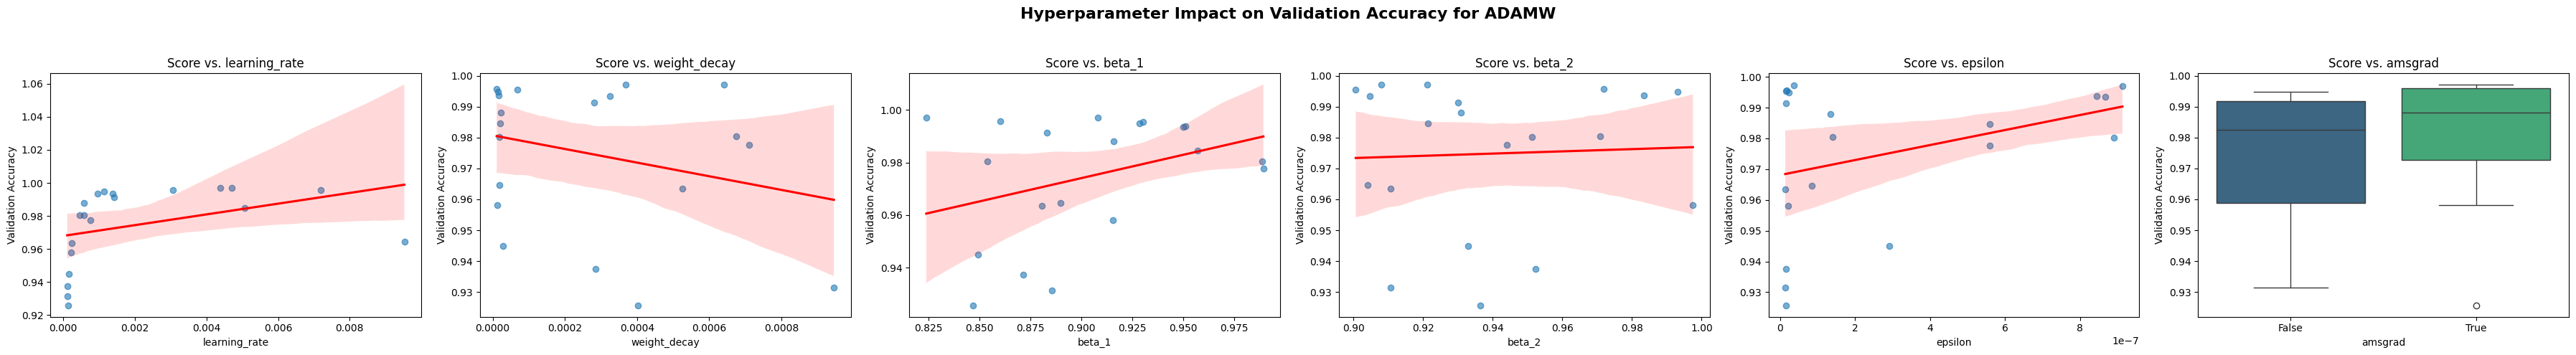

In [ ]:
plot_hparam_impact(all_tuners['adamw'], 'ADAMW')

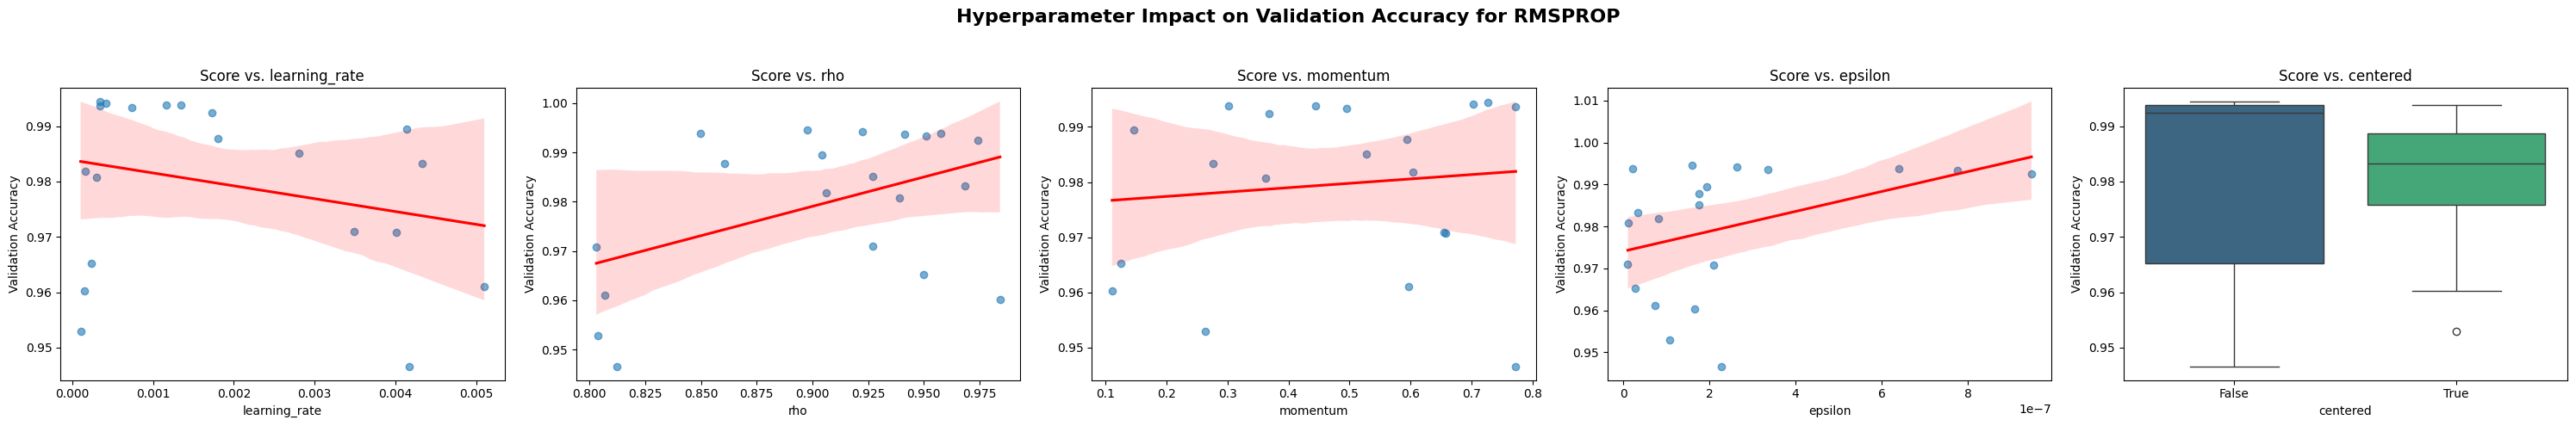

In [ ]:
plot_hparam_impact(all_tuners['rmsprop'], 'RMSProp')

--- Plotting Final Performance Summary (5-Fold CV Averages) ---


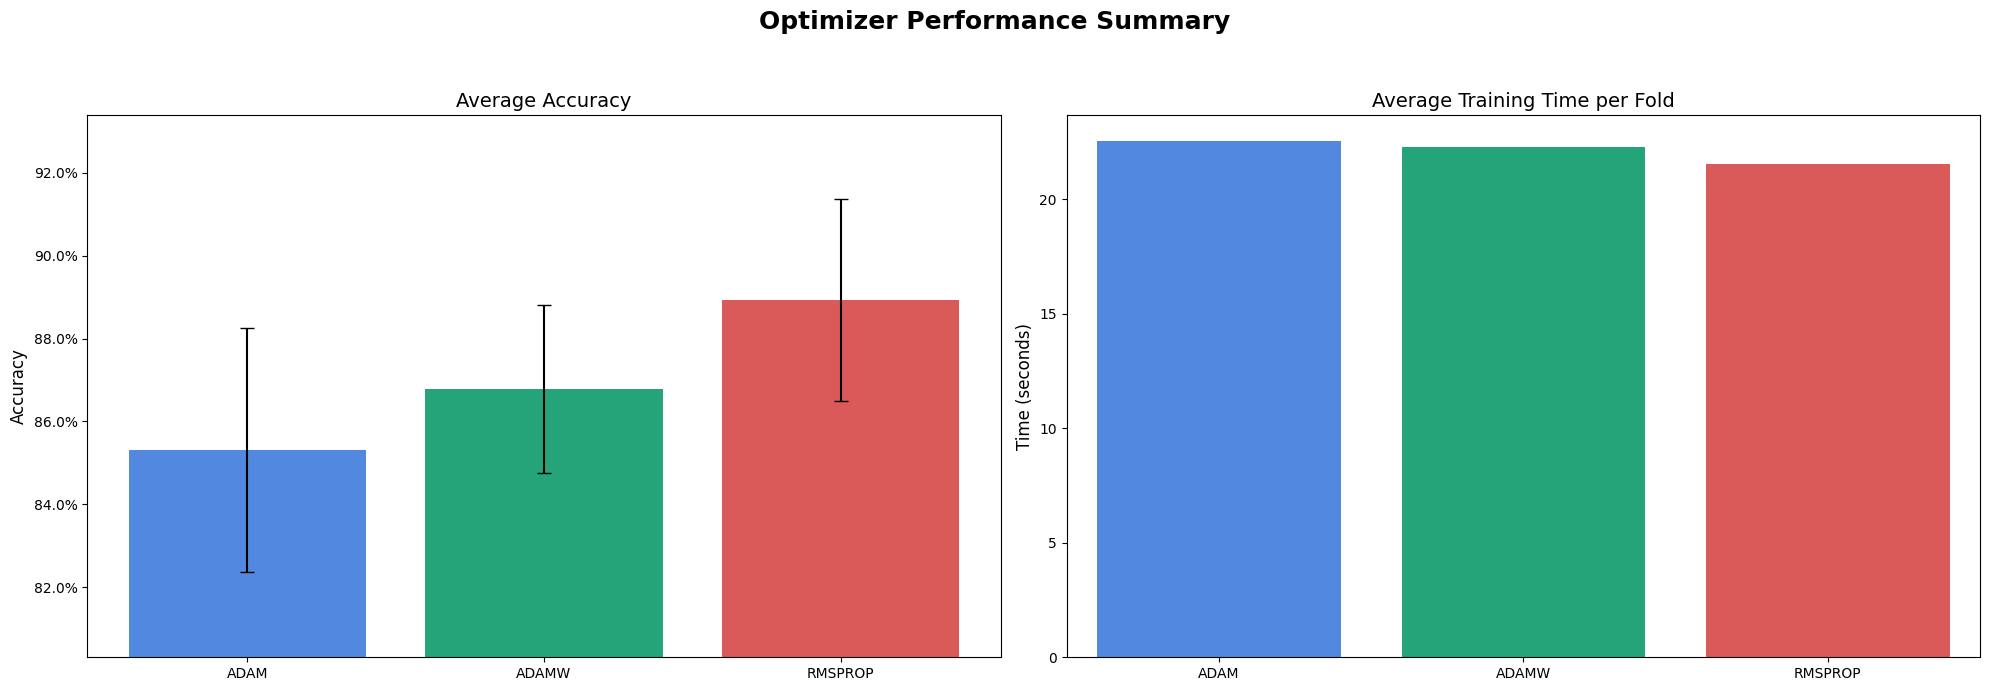

In [ ]:
print("--- Plotting Final Performance Summary (5-Fold CV Averages) ---")
fig, (ax_bar_acc, ax_bar_time) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Optimizer Performance Summary', fontsize=18, fontweight='bold')
bar_colors = [colors[opt] for opt in results_df['Optimizer']]

# Bar chart for Accuracy
sns.barplot(x='Optimizer', y='Avg. Accuracy', data=results_df, ax=ax_bar_acc, palette=bar_colors, hue='Optimizer', dodge=False, legend=False)
ax_bar_acc.set_title('Average Accuracy', fontsize=14)
ax_bar_acc.set_ylabel('Accuracy', fontsize=12)
ax_bar_acc.set_xlabel('')
ax_bar_acc.set_ylim(bottom=max(0, results_df['Avg. Accuracy'].min() - 0.05))
ax_bar_acc.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
# Add error bars manually
ax_bar_acc.errorbar(x=results_df['Optimizer'], y=results_df['Avg. Accuracy'], yerr=results_df['Std. Dev. Accuracy'], fmt='none', c='black', capsize=5)

# Bar chart for Training Time
sns.barplot(x='Optimizer', y='Avg. Training Time (s)', data=results_df, ax=ax_bar_time, palette=bar_colors, hue='Optimizer', dodge=False, legend=False)
ax_bar_time.set_title('Average Training Time per Fold', fontsize=14)
ax_bar_time.set_ylabel('Time (seconds)', fontsize=12)
ax_bar_time.set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

--- Reloading saved tuner data... ---
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adam/tuner0.json
  > Loaded data for ADAM
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adamw/tuner0.json
  > Loaded data for ADAMW
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_rmsprop/tuner0.json
  > Loaded data for RMSPROP

--- Plotting Bayesian Optimization Convergence for All Optimizers ---


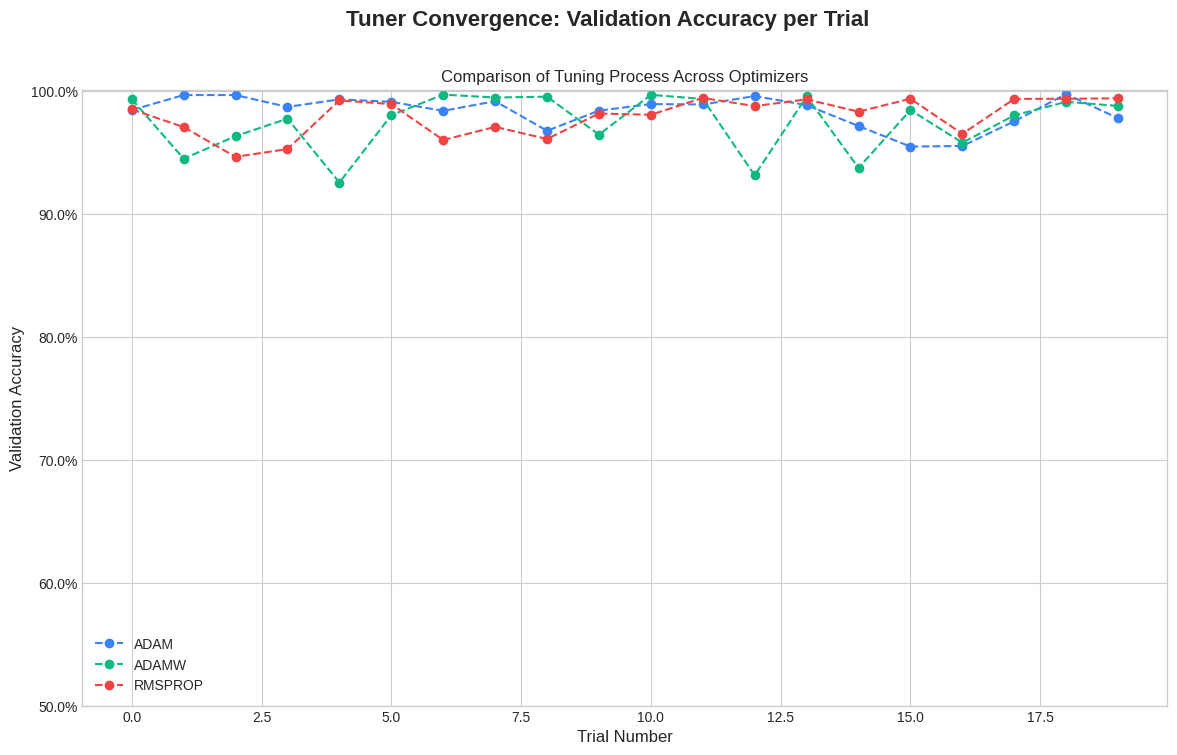

In [ ]:
# --- Reload Tuner Objects ---
# We instantiate the tuners again with the same project names.
# KerasTuner will automatically load the saved results instead of re-running the search.

print("--- Reloading saved tuner data... ---")
all_tuners = {}
OPTIMIZERS_TO_TEST = ['adam', 'adamw', 'rmsprop']

for optimizer_name in OPTIMIZERS_TO_TEST:
    hp = kt.HyperParameters()
    hp.Fixed('optimizer', optimizer_name)

    tuner = kt.BayesianOptimization(
        hypermodel=FFN_model,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=MAX_TRIALS_HPO,
        directory='bayesian_hpo_dir_live',
        project_name=f'kmnist_bayes_{optimizer_name}'
    )
    # This line reloads the existing project state
    tuner.reload()
    all_tuners[optimizer_name] = tuner
    print(f"  > Loaded data for {optimizer_name.upper()}")

# --- Plot Bayesian Optimization Convergence ---
print("\n--- Plotting Bayesian Optimization Convergence for All Optimizers ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
fig.suptitle('Tuner Convergence: Validation Accuracy per Trial', fontsize=16, fontweight='bold')
colors = {'adam': '#3b82f6', 'adamw': '#10b981', 'rmsprop': '#ef4444'}

for optimizer_name, tuner in all_tuners.items():
    # CORRECTED LINE: Use the MAX_TRIALS_HPO constant to get all trials.
    trials = tuner.oracle.get_best_trials(num_trials=MAX_TRIALS_HPO)

    # Sort the trials by their execution order (trial_id) to see the progression
    trial_ids = [int(trial.trial_id) for trial in trials]
    scores = [trial.score for trial in trials]

    if not trial_ids:
        print(f"No trial data found for {optimizer_name}, skipping plot.")
        continue

    sorted_trials = sorted(zip(trial_ids, scores))
    sorted_ids, sorted_scores = zip(*sorted_trials)

    ax.plot(sorted_ids, sorted_scores, marker='o', linestyle='--', label=optimizer_name.upper(), color=colors[optimizer_name.lower()])

ax.set_xlabel('Trial Number', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.legend()
ax.grid(True)
ax.set_title('Comparison of Tuning Process Across Optimizers')
ax.set_ylim(bottom=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.show()

In [ ]:
# --- Reload Tuner Objects ---
# This reloads the results from your previously completed run.
print("--- Reloading saved tuner data... ---")
all_tuners = {}
OPTIMIZERS_TO_TEST = ['adam', 'adamw', 'rmsprop']

for optimizer_name in OPTIMIZERS_TO_TEST:
    hp = kt.HyperParameters()
    hp.Fixed('optimizer', optimizer_name)

    tuner = kt.BayesianOptimization(
        hypermodel=FFN_model,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=MAX_TRIALS_HPO,
        directory='bayesian_hpo_dir_live',
        project_name=f'kmnist_bayes_{optimizer_name}'
    )
    tuner.reload()
    all_tuners[optimizer_name] = tuner
    print(f"  > Loaded data for {optimizer_name.upper()}")

# --- Create Interactive Plot with Hover-Over Details ---
print("\n--- Plotting Interactive Bayesian Optimization Convergence ---")

fig = go.Figure()
# CORRECTED LINE: Dictionary keys are now lowercase to match the loop variable.
colors = {'adam': '#3b82f6', 'adamw': '#10b981', 'rmsprop': '#ef4444'}

for optimizer_name, tuner in all_tuners.items():
    # Extract trial data into a pandas DataFrame for easier handling
    trials = tuner.oracle.get_best_trials(num_trials=MAX_TRIALS_HPO)

    if not trials:
        print(f"No trial data found for {optimizer_name}, skipping plot.")
        continue

    trial_data = []
    for trial in trials:
        data_point = {'trial_id': int(trial.trial_id), 'score': trial.score}
        data_point.update(trial.hyperparameters.values)
        trial_data.append(data_point)

    df = pd.DataFrame(trial_data).sort_values(by='trial_id')

    # Define which hyperparameters to show in the hover tooltip
    hover_params = [col for col in df.columns if col not in ['optimizer', 'score', 'trial_id', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round']]

    # Create the hover text for each point
    hover_text = []
    for index, row in df.iterrows():
        text = f"<b>Trial:</b> {row['trial_id']}<br><b>Score:</b> {row['score']:.4f}<br><br><b>Parameters:</b><br>"
        for param in hover_params:
            value = row.get(param)
            if isinstance(value, float):
                text += f"  {param}: {value:.5f}<br>"
            else:
                text += f"  {param}: {value}<br>"
        hover_text.append(text)

    # Add the line (trace) to the figure
    fig.add_trace(go.Scatter(
        x=df['trial_id'],
        y=df['score'],
        mode='lines+markers',
        name=optimizer_name.upper(),
        line=dict(color=colors[optimizer_name.lower()]),
        marker=dict(size=8),
        hoverinfo='text',
        hovertext=hover_text
    ))

# --- Update Figure Layout ---
fig.update_layout(
    title_text='<b>Tuner Convergence: Validation Accuracy per Trial (Hover for Details)</b>',
    xaxis_title='Trial Number',
    yaxis_title='Validation Accuracy',
    yaxis_tickformat='.1%',
    legend_title_text='Optimizer',
    template='plotly_white'
)

fig.show()

--- Reloading saved tuner data... ---
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adam/tuner0.json
  > Loaded data for ADAM
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adamw/tuner0.json
  > Loaded data for ADAMW
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_rmsprop/tuner0.json
  > Loaded data for RMSPROP

--- Plotting Interactive Bayesian Optimization Convergence ---


--- Reloading saved tuner data... ---
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adam/tuner0.json
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_adamw/tuner0.json
Reloading Tuner from bayesian_hpo_dir_live/kmnist_bayes_rmsprop/tuner0.json

--- Generating Annotated Hyperparameter Impact Plots for: ADAM ---


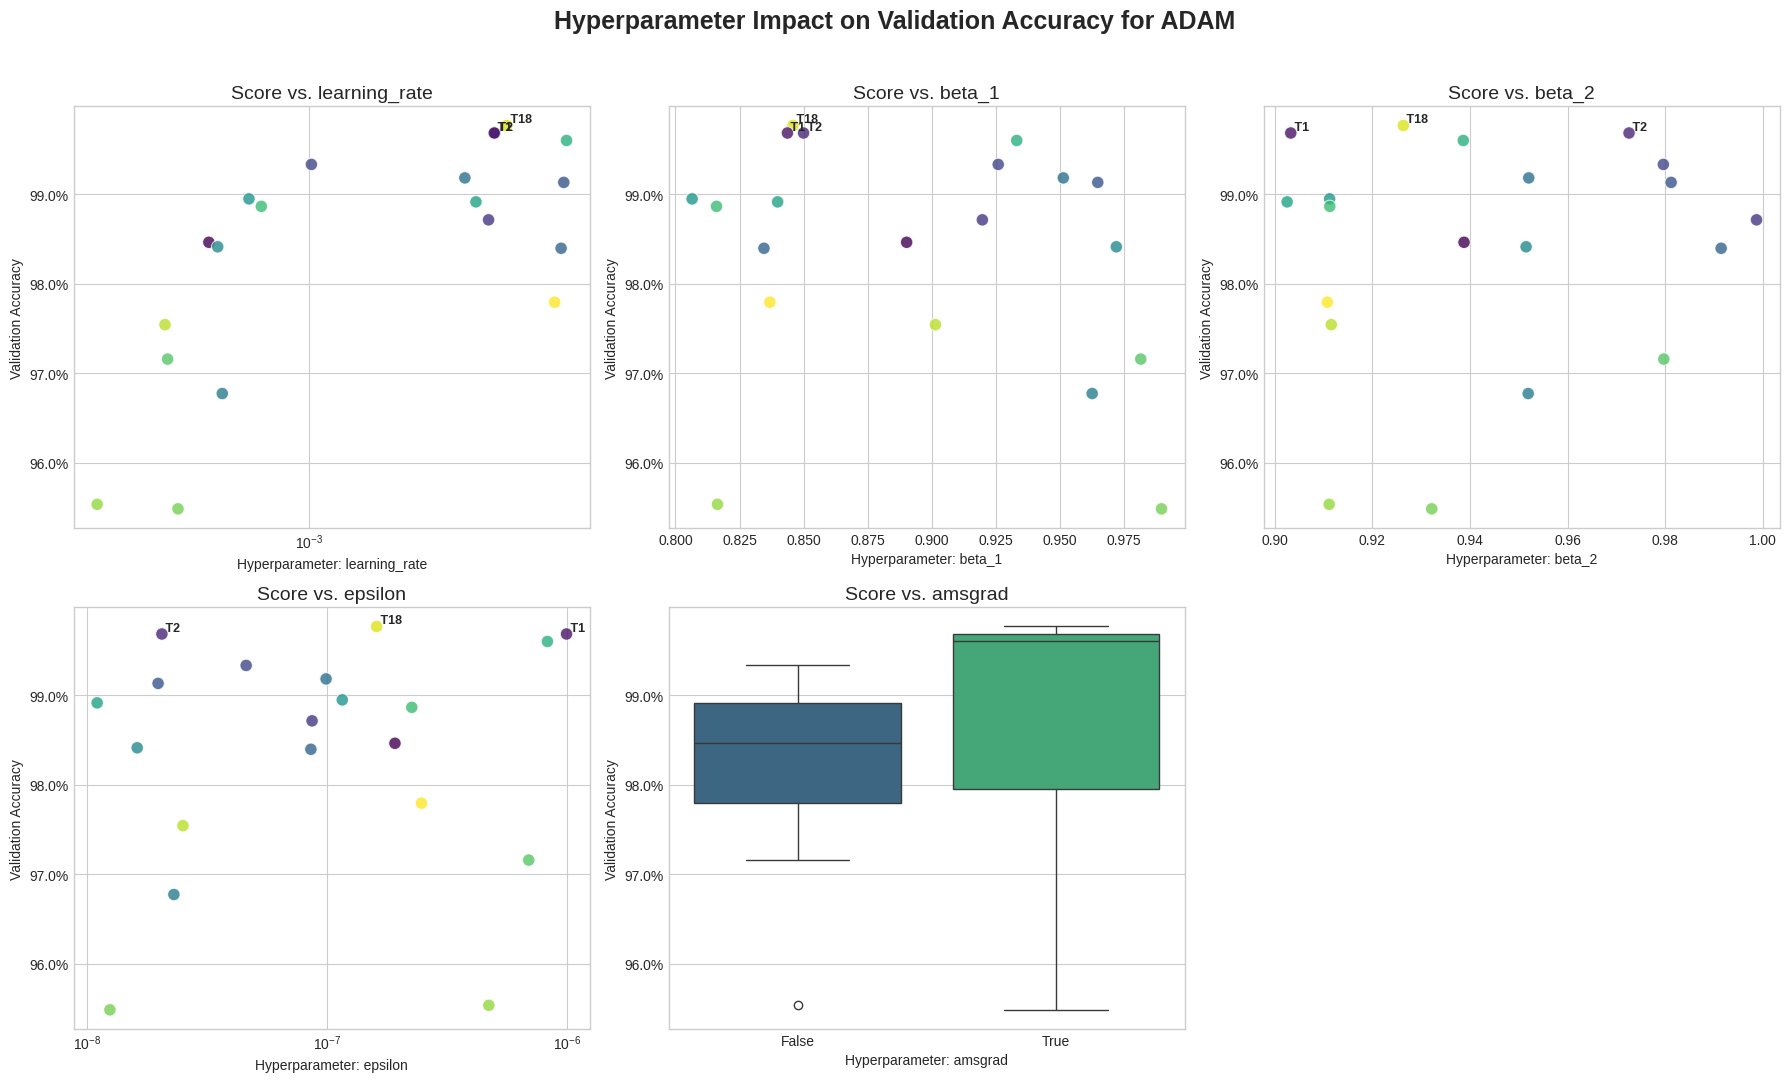


--- Generating Annotated Hyperparameter Impact Plots for: ADAMW ---


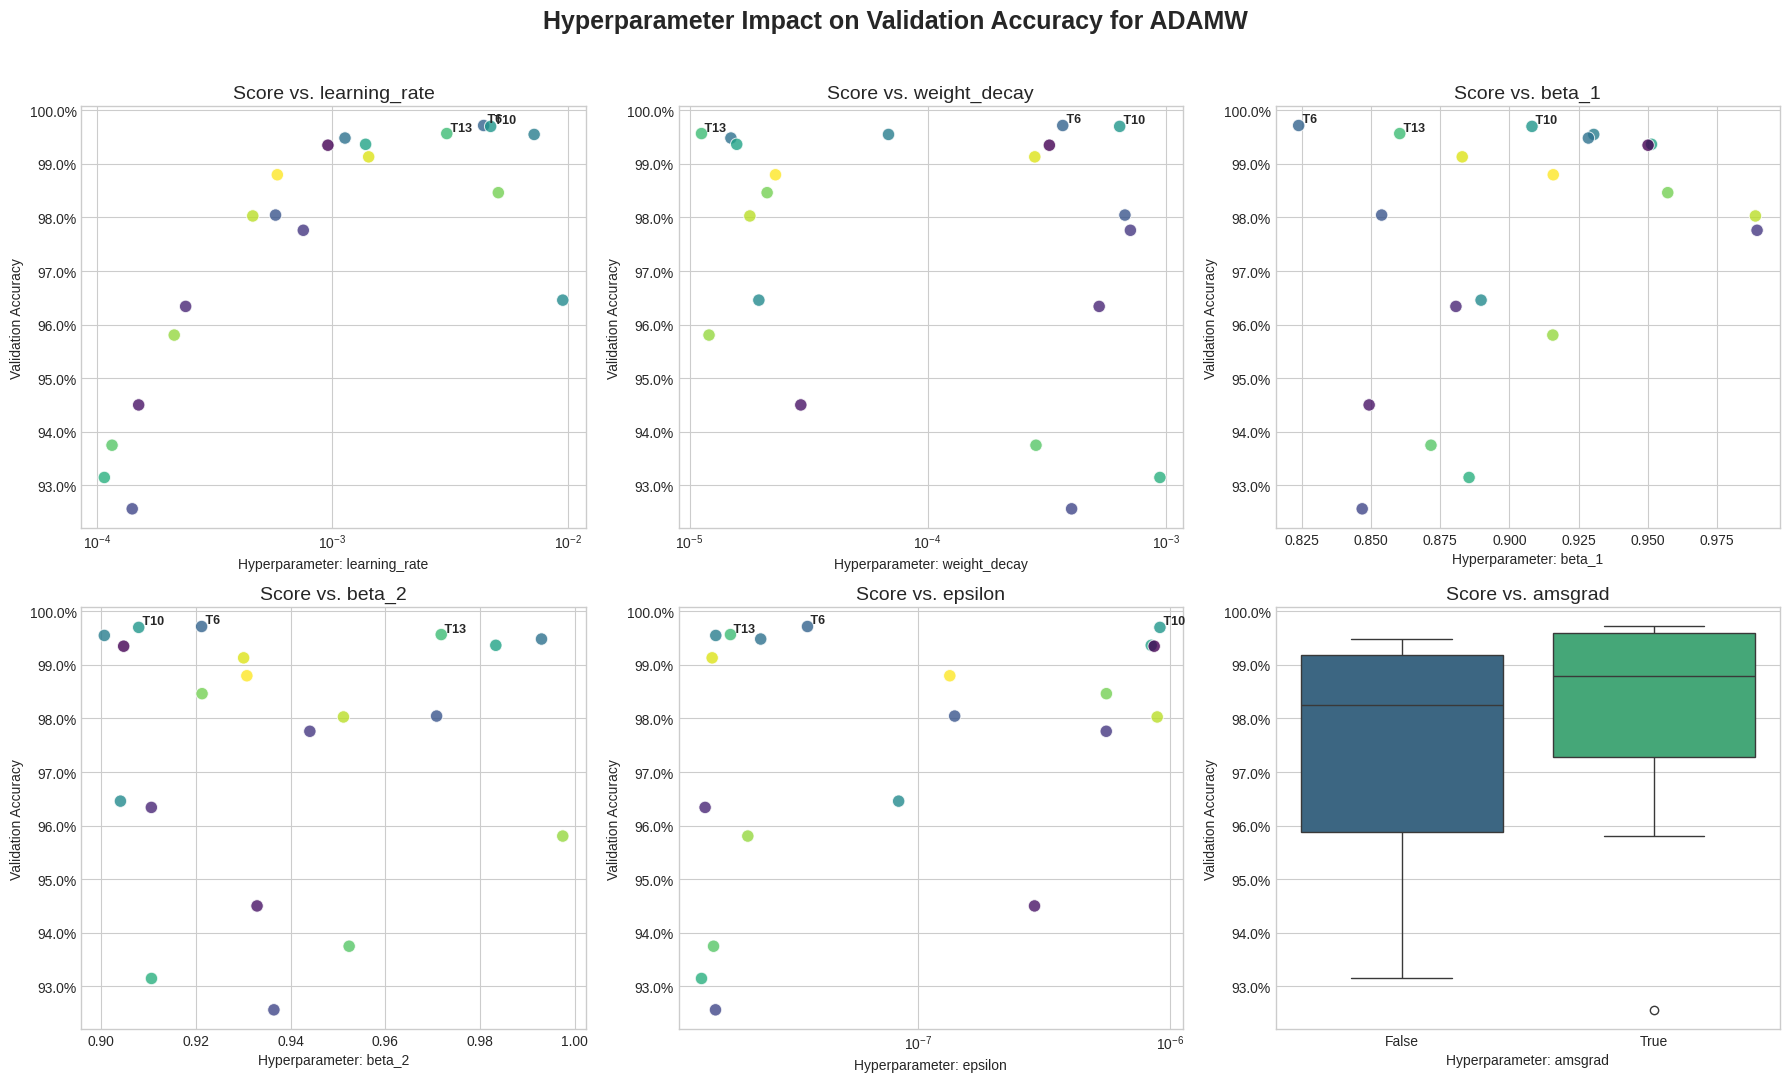


--- Generating Annotated Hyperparameter Impact Plots for: RMSPROP ---


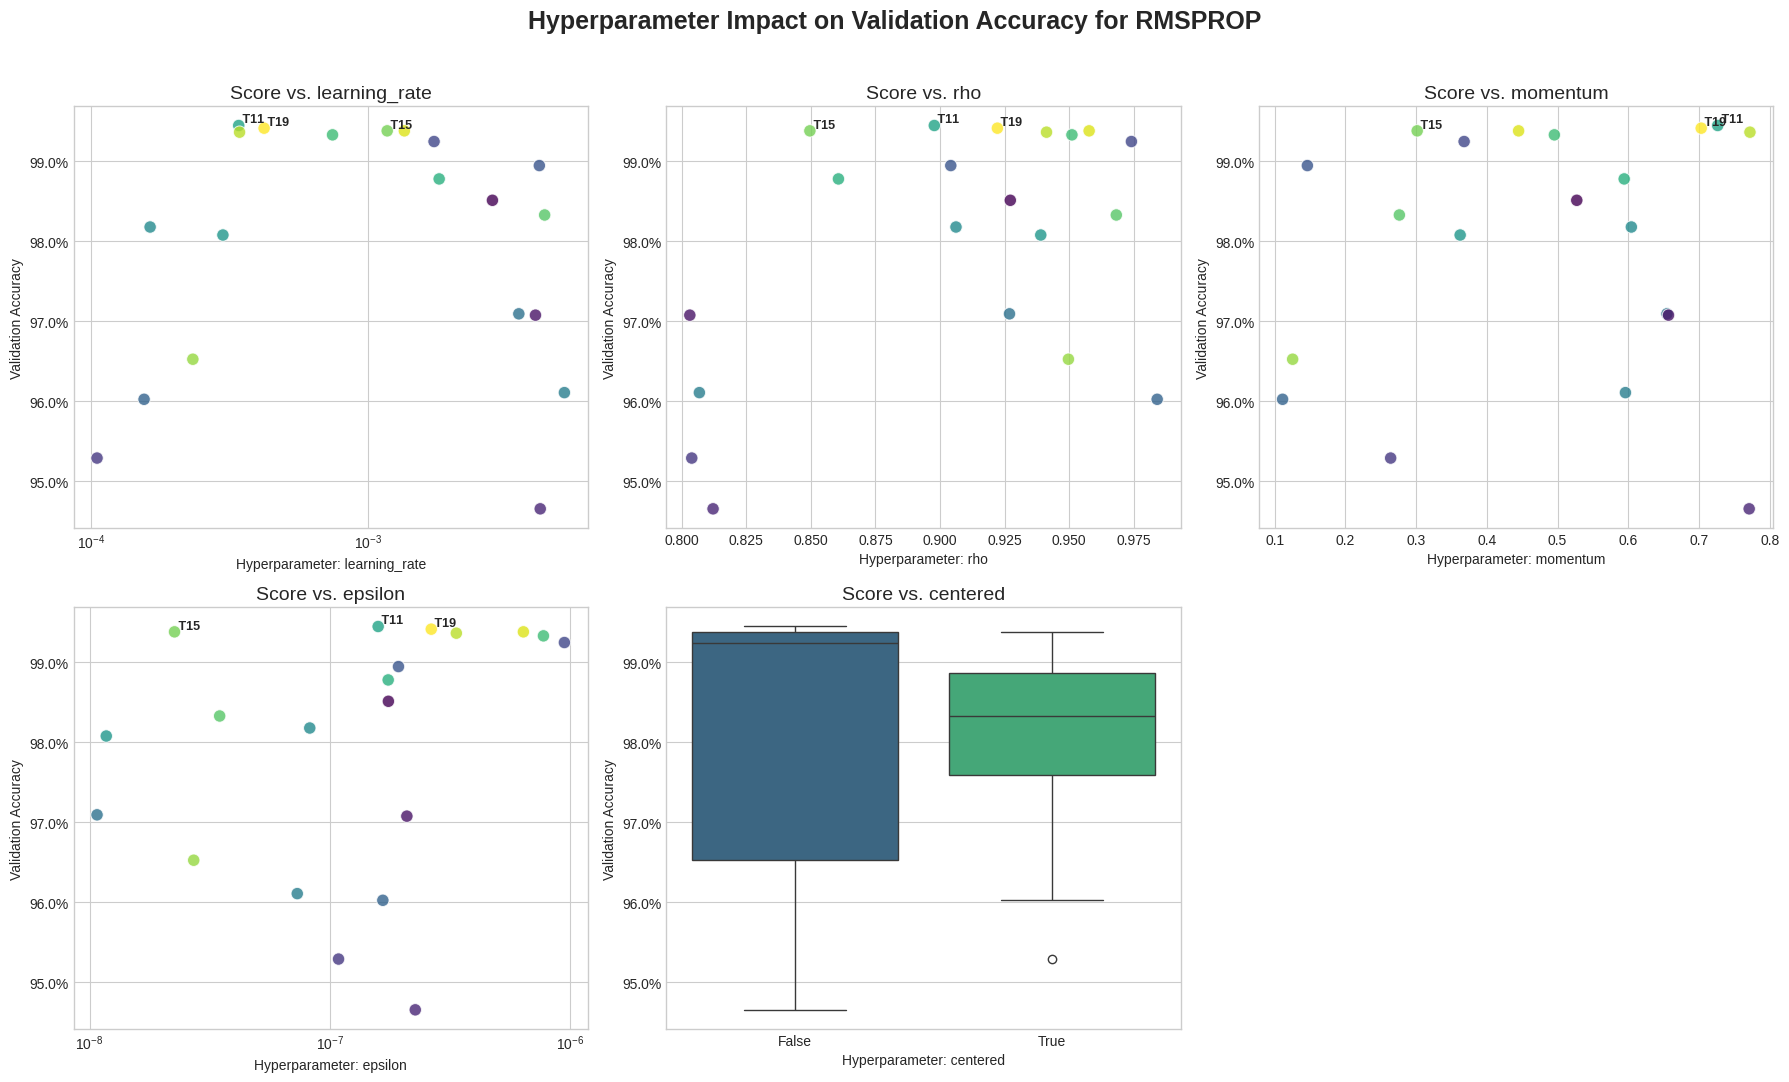

In [ ]:
def plot_static_hparam_impact_with_table(tuner, optimizer_name):
    """
    Processes tuner trial data and creates a grid of static plots showing the
    impact of each hyperparameter, highlighting the best trial and adding a
    full data table below.
    """
    print(f"\n--- Generating Annotated Hyperparameter Impact Plots for: {optimizer_name.upper()} ---")

    trials = tuner.oracle.get_best_trials(num_trials=MAX_TRIALS_HPO)

    if not trials:
        print(f"No trial data found for {optimizer_name}, skipping plots.")
        return

    trial_data = []
    for trial in trials:
        data_point = {'trial_id': int(trial.trial_id), 'score': trial.score}
        data_point.update(trial.hyperparameters.values)
        trial_data.append(data_point)

    df = pd.DataFrame(trial_data)

    hparam_cols = [col for col in df.columns if col not in ['optimizer', 'score', 'trial_id', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round']]
    num_params = len(hparam_cols)

    if num_params == 0:
        return

    ncols = 3
    nrows = math.ceil(num_params / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 5.5), squeeze=False)
    axes = axes.flatten()

    fig.suptitle(f'Hyperparameter Impact on Validation Accuracy for {optimizer_name.upper()}', fontsize=18, fontweight='bold')

    # Get top trials for annotation
    best_trial = df.loc[df['score'].idxmax()]
    top_5_trials = df.nlargest(5, 'score')

    for i, param in enumerate(hparam_cols):
        ax = axes[i]

        # Plot for boolean/categorical parameters
        if df[param].dtype == 'bool' or df[param].nunique() < 5:
            sns.boxplot(x=param, y='score', data=df, ax=ax, palette='viridis')
            ax.set_xlabel(f'Hyperparameter: {param}')
        # Plot for continuous (float) parameters
        else:
            # Color points by trial number to show progression
            sns.scatterplot(
                x=param,
                y='score',
                data=df,
                ax=ax,
                hue='trial_id',
                palette='viridis',
                legend=False,
                s=80,
                alpha=0.7
            )
            ax.set_xlabel(f'Hyperparameter: {param}')
            if 'learning_rate' in param or 'weight_decay' in param or 'epsilon' in param:
                ax.set_xscale('log')

            # Highlight the single best trial with a red star
            ax.scatter(best_trial[param], best_trial['score'], marker='*', s=400, color='red', zorder=3, label='Best Trial')

            # Annotate the top 5 trials
            for idx, row in top_5_trials.iterrows():
                ax.text(row[param], row['score'], f" T{row['trial_id']}", fontsize=9, verticalalignment='bottom', fontweight='bold')

        ax.set_title(f'Score vs. {param}', fontsize=14)
        ax.set_ylabel('Validation Accuracy')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Display the detailed table for all trials ---
    display_df = df[['trial_id', 'score'] + hparam_cols].sort_values(by='trial_id').set_index('trial_id')
    print(f"\n--- Full Trial Data for {optimizer_name.upper()} ---")
    display(display_df.style.format({'score': "{:.4f}"}).background_gradient(cmap='viridis', subset=['score']))


# --- Reload Tuner Objects ---
print("--- Reloading saved tuner data... ---")
all_tuners = {}
OPTIMIZERS_TO_TEST = ['adam', 'adamw', 'rmsprop']

for optimizer_name in OPTIMIZERS_TO_TEST:
    hp = kt.HyperParameters()
    hp.Fixed('optimizer', optimizer_name)

    tuner = kt.BayesianOptimization(
        hypermodel=FFN_model,
        hyperparameters=hp,
        objective='val_accuracy',
        max_trials=MAX_TRIALS_HPO,
        directory='bayesian_hpo_dir_live',
        project_name=f'kmnist_bayes_{optimizer_name}'
    )
    tuner.reload()
    all_tuners[optimizer_name] = tuner

# --- Generate the plots and tables for each optimizer ---
plot_static_hparam_impact_annotated(all_tuners['adam'], 'ADAM')
plot_static_hparam_impact_annotated(all_tuners['adamw'], 'AdamW')
plot_static_hparam_impact_annotated(all_tuners['rmsprop'], 'RMSprop')